# Price Impact Analysis (Case: RTS)

In this analysis, we want to study the structure of Price Impact / Price formation in electricity markets.

## Dependencies and Data Preparation

#### Packages and Diretory

In [1]:
#make sure it is in "GridAnalysis.jl" 
cd("/home/rafaela/Documents/PUC/LAMPS/github/GridAnalysis.jl")

In [2]:
pwd()

"/home/rafaela/Documents/PUC/LAMPS/github/GridAnalysis.jl"

In [3]:
using Pkg
Pkg.activate("./examples/RTS/price_impact_analysis_RTS")

In [4]:
Pkg.instantiate()

In [5]:
using Logging 
Logging.disable_logging(Logging.Info) #script to disable info messages 
Logging.disable_logging(Logging.Warn) #script to disable warning messages

LogLevel(1001)

In [6]:
using Dates
using DataFrames
using GridAnalysis
using Gurobi
using PowerSystems
using PowerSimulations
using Test
using Measures
using Plots

const PSY = PowerSystems

PowerSystems

#### Getting the data

In [7]:
# set directory
rts_dir = download("https://github.com/GridMod/RTS-GMLC", "master", mktempdir())
# Or clone the directory and open as:
# for example: rts_dir = "/home/rafaela/Documents/PUC/LAMPS/github/RTS-GMLC"
rts_src_dir = joinpath(rts_dir, "RTS_Data", "SourceData")
rts_siip_dir = joinpath(rts_dir, "RTS_Data", "FormattedData", "SIIP");

#### Uploading Utils

Might not work if running lines manually 
(solution: edit to be the path for this examples directory for example: 'example_dir = "./examples/RTS/"')

In [8]:
example_dir = "./examples/RTS/"

include(joinpath(example_dir, "utils.jl")) # case utilities
include(joinpath(example_dir, "modify_RTS.jl")) # functions that modify the RTS problem

rts_modifier_function!

#### Data Prep and Build Market Simulator
define solvers for Unit Commitment (UC), Real Time (RT) and Economic Dispatch (ED)

In [9]:
solver_uc = optimizer_with_attributes(Gurobi.Optimizer)
solver_rt = optimizer_with_attributes(Gurobi.Optimizer)
solver_ed = optimizer_with_attributes(Gurobi.Optimizer)

MathOptInterface.OptimizerWithAttributes(Gurobi.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[])

## Define analysis to be done

In [10]:
Network = [DCPPowerModel];
Ramp = [true];
Minimal_generation = [true];
Reserve = [true];
Offer_Bus = ["Austen", "Bloch", "Chifa"]; # the two buses with the highest PMax (MW)
bidding_period = [collect(1:24), [1]];

#### Create a DataFrame where each line represents one analysis 

In [11]:
df = DataFrame(Network = [], 
               Ramp = [],
               Minimal_generation = [],
               Reserve = [],
               Offer_Bus = [],
               bidding_period = []) 

for a in Network 
    for b in Ramp 
        for c in Minimal_generation 
            for d in Reserve
                for e in Offer_Bus
                    for f in bidding_period
                        new_data = DataFrame(Network = [Dict("DA"=>a, "RT"=>a)], 
                        Ramp = [Dict("DA"=>b, "RT"=>b)],
                        Minimal_generation = [Dict("DA"=>c, "RT"=>c)],
                        Reserve = [d],
                        Offer_Bus = [e],
                        bidding_period = [f])
                        append!(df, new_data)
                    end
                end
            end
        end
    end
end
df[!,5:6]

,Offer_Bus,bidding_period
,Any,Any
1,Austen,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
2,Austen,[1]
3,Bloch,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
4,Bloch,[1]


#### Define range quota and period to be analysed

In [12]:
range_quota = Float64.(collect(0:1:4));
initial_time = Date("2020-09-01");
period_analysed = [5,16,19,21];
initial_bidding_time = DateTime("2020-09-01");
path = "results";

## Run all the simulations

In [13]:
run_set_of_simulations(df, rts_src_dir, rts_siip_dir, example_dir, solver_uc, solver_ed, solver_rt,
    range_quota, initial_time, initial_bidding_time, path)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
  Step:                  1
  problem:               RT
  Simulation Timestamp:  2020-09-01T23:45:00


### Locality Impact: What is the impact of the virtual offer as we move away from the offer node? 

Node relationship metrics to be used:

1. Price change at connected and non-connected nodes to the offer node;
2. Price change according to the distance to the offer node. Where "distance" refers to the number of buses between them;
3. Price change according to the bottleneck between the buses and the offer node. Where "bottleneck" is related to the trasmission lines capacity limits.

##### Load the simulation done previously 

In [27]:
lines=[1,3]
period_analysed=[[5],[16],[19],[21]] 

4-element Vector{Vector{Int64}}:
 [5]
 [16]
 [19]
 [21]

In [28]:
graphic = "plot_price_curves"
plt_f = load_plot_set_of_simulations(df, example_dir, rts_src_dir, rts_siip_dir, solver_uc, solver_ed, solver_rt,
        range_quota, initial_time, lines, period_analysed, initial_bidding_time, path, graphic, false)
plt_t = load_plot_set_of_simulations(df, example_dir, rts_src_dir, rts_siip_dir, solver_uc, solver_ed, solver_rt,
        range_quota, initial_time, lines, period_analysed, initial_bidding_time, path, graphic, true)

2×4 Matrix{Any}:
 Plot{Plots.GRBackend() n=4}  …  Plot{Plots.GRBackend() n=4}
 Plot{Plots.GRBackend() n=4}     Plot{Plots.GRBackend() n=4}

#### Results

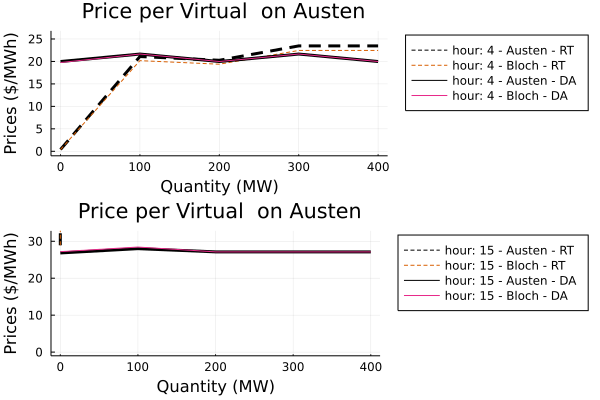

In [79]:
plot(plt_t[1,1],plt_t[1,2],layout=(2,1))

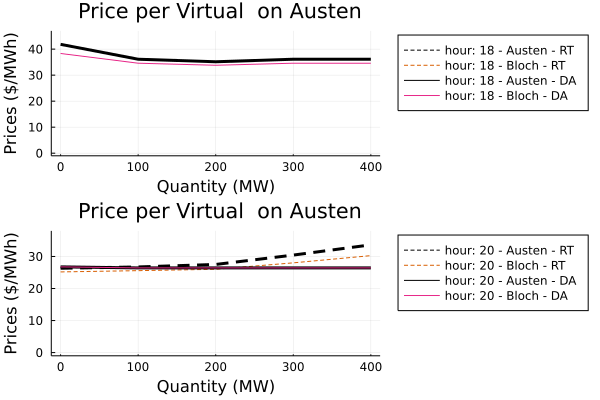

In [80]:
plot(plt_t[1,3],plt_t[1,4],layout=(2,1))

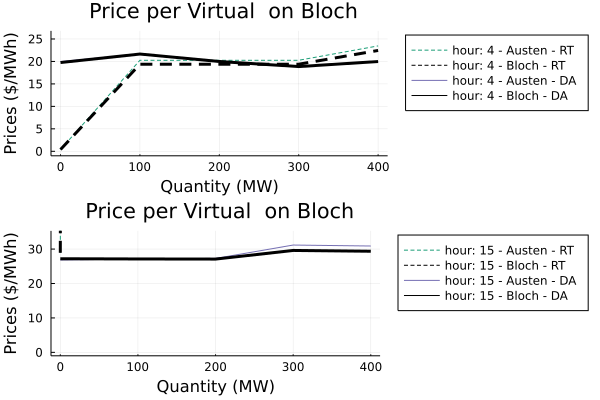

In [29]:
plot(plt_t[2,1],plt_t[2,2],layout=(2,1))

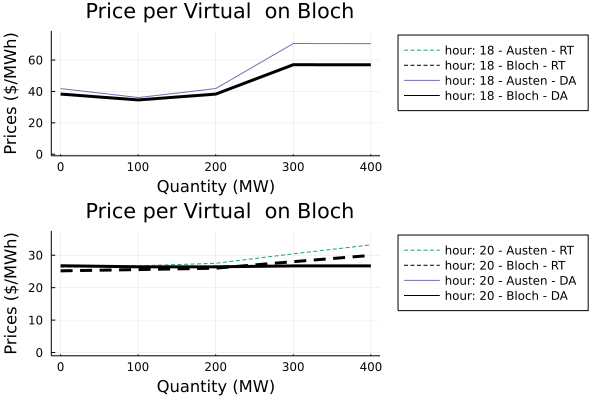

In [30]:
plot(plt_t[2,3],plt_t[2,4],layout=(2,1))

In [ ]:
plot(plt_t[3,1],plt_t[3,2],layout=(2,1))

In [ ]:
plot(plt_t[3,3],plt_t[3,4],layout=(2,1))

### Hour Impact: What is the impact of the virtual offer as we move away from the offer period?
Proposed evaluation experiment: Make an offer in the first hour and see the impact in the other hours.

#### Load the simulation done previously

In [14]:
lines=[2,4]
period_analysed=[[5],[16],[19],[21]] 

4-element Vector{Vector{Int64}}:
 [5]
 [16]
 [19]
 [21]

In [84]:
graphic = "plot_price_curves"
plt_hf = load_plot_set_of_simulations(df, example_dir, rts_src_dir, rts_siip_dir, solver_uc, solver_ed, solver_rt,
        range_quota, initial_time, lines, period_analysed, initial_bidding_time, path, graphic, false)
plt_h = load_plot_set_of_simulations(df, example_dir, rts_src_dir, rts_siip_dir, solver_uc, solver_ed, solver_rt,
        range_quota, initial_time, lines, period_analysed, initial_bidding_time, path, graphic, true)

2×4 Matrix{Any}:
 Plot{Plots.GRBackend() n=4}  …  Plot{Plots.GRBackend() n=4}
 Plot{Plots.GRBackend() n=4}     Plot{Plots.GRBackend() n=4}

#### Results

### Price

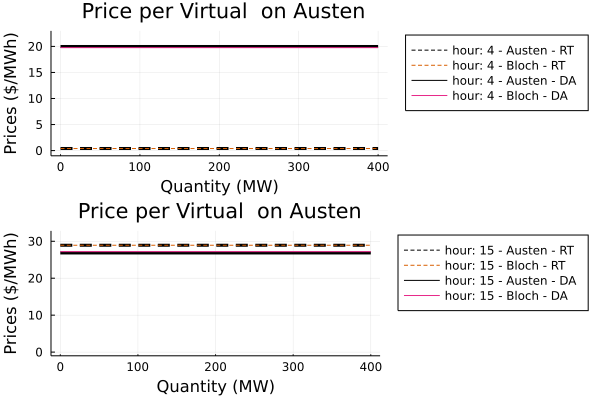

In [85]:
plot(plt_h[1,1],plt_h[1,2],layout=(2,1))

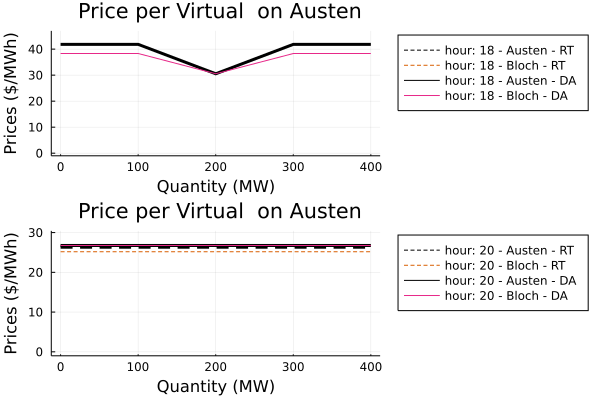

In [86]:
plot(plt_h[1,3],plt_h[1,4],layout=(2,1))

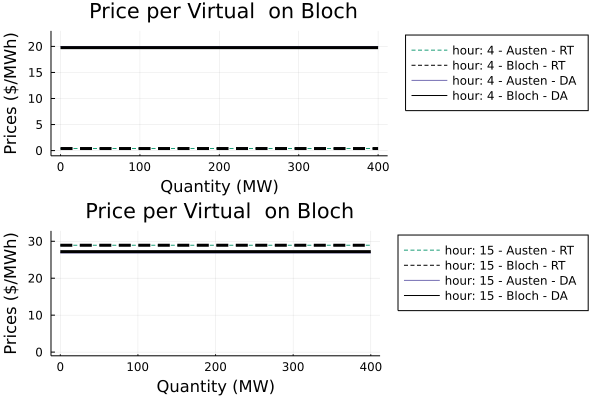

In [87]:
plot(plt_h[2,1],plt_h[2,2],layout=(2,1))

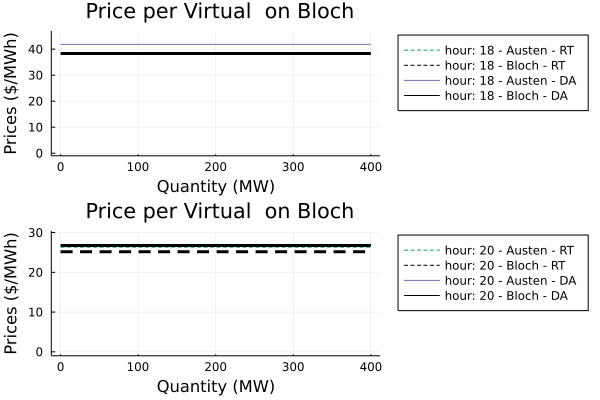

In [89]:
plot(plt_h[2,3],plt_h[2,4],layout=(2,1))

In [ ]:
plot(plt_h[3,1],plt_h[3,2],layout=(2,1))

In [ ]:
plot(plt_h[3,3],plt_h[3,4],layout=(2,1))